In [101]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import open3d as o3d
import glob
from  matplotlib.colors import LinearSegmentedColormap

In [110]:
class visual_fusion(object):
    def __init__(self, calibration_files):
        '''
        Velo-To-Cam is a variable we'll call V2C -- It gives the rotation and translation matrices from the Velodyne to the Left Grayscale camera.
        R0_rect is used in Stereo Vision to make the images co-planar. It's our case here.
        P_matrix is the matrix obtained after camera calibration. It contains the intrinsic matrix K and the extrinsic.
        '''
        calibrations = self.read_calibrations(calibration_files)
        velo_to_cam_R = calibrations["velo_to_cam_R"]
        velo_to_cam_T = calibrations["velo_to_cam_T"]
        R0 = calibrations["R_rect_00"]
        p_matrix = calibrations["P_rect_02"]
        
        self.velo_to_cam = np.column_stack([np.reshape(velo_to_cam_R, [3,3]),np.reshape(velo_to_cam_T,[3,1])])
        self.R0 = np.reshape(R0, [3,3])
        self.p_matrix = np.reshape(p_matrix, [3,4])
        
        #create a colormap for pointcloud display...creates a gradient hue fromr red to green of self.N shape
        self.N = 300   # arbitrary value
        cmap =  LinearSegmentedColormap.from_list("", ["green","yellow","red"],N=self.N)        
        self.cmap = np.array([cmap(i) for i in range(self.N)])[:, :3]

        
        
    def read_calibrations(self,calibration_files):
        """ Read in a calibration file and parse into a dictionary.
        Ref: https://github.com/utiasSTARS/pykitti/blob/master/pykitti/utils.py
        """
        data = {}
        with open(calibration_files, "r") as f:
            for line in f.readlines():
                line = line.rstrip()
                if len(line) == 0:
                    continue
                key,value = line.split(":",1)
                #the only non-float values in these files are dates, which we don't care about
                try:
                    data[key] = np.array([float(x) for x in value.split()])
                except ValueError:
                    pass
        return data
    
    def lidar_points_to_image_points(self,lidar_points,image,depth_threshold):
        '''
        Input: 3D points in Velodyne Frame [nx3], Image, Depth threshold
        Output: 2D Pixels in Image Frame [nx2], 3D points in Velodyne Frame [nx3]
        Apply formula P x R0 x RT x X 
        Segment by depth
        '''
        # convert to homogeneous coordinates
        R0_h = np.vstack([self.R0, [0,0,0]])
        R0_homo = np.column_stack([R0_h, [0,0,0,1]])
        
        p_matrix_and_R0 = np.dot(self.p_matrix, R0_homo)  #P x R0
        p_matrix_and_R0_and_RT = np.dot(p_matrix_and_R0, np.vstack((self.velo_to_cam,[0,0,0,1]))) # P x R0 x RT
        p3d_points = np.column_stack([lidar_points,np.ones((lidar_points.shape[0],1))])#4x1
        
        p_matrix_and_R0_and_RT_and_X= np.dot(p_matrix_and_R0_and_RT, np.transpose(p3d_points)) #P x R0 x RT x X 
        p2d_points = np.transpose(p_matrix_and_R0_and_RT_and_X) #transpose into correct format
        
        #normalize and convert to 2d image coordinates
        p2d_points[:, 0] /= p2d_points[:, 2]
        p2d_points[:, 1] /= p2d_points[:, 2]
        new_2d_points = p2d_points[:, 0:2]
        
        
        img_min_x = 0
        img_min_y = 0
        img_max_x = image.shape[1]
        img_max_y = image.shape[0]
        #collect only points in image.
        
        image_fov = ((new_2d_points[:, 0] < img_max_x)& (new_2d_points[:, 0] >= img_min_x) &
                    (new_2d_points[:, 1] < img_max_y) & (new_2d_points[:, 1] >= img_min_y))
        
        #segment points by depth (depth is x-axis for lidar) 
        #find the points in the image and within a certain threshold
        segment_by_depth = image_fov & (lidar_points[:,0] > depth_threshold) 
        segment_by_depth_3d = lidar_points[segment_by_depth, :]  #collect the 3d points that qualify
        segment_by_depth_2d = new_2d_points[segment_by_depth, :] #collect the 2d points that qualify
        
        return new_2d_points, segment_by_depth_3d, segment_by_depth_2d
    
    
    
    def display_lidar_points_on_image(self,image,lidar_points):
        '''
        Input: 3D points in Velodyne Frame [nx3], Image
        Output: Image
        Apply colormap
        '''
        cut_off_depth = 2.0 # meters
        p2d_points, p3d_points_in_image, p2d_points_in_image = self.lidar_points_to_image_points(lidar_points,image,cut_off_depth)
        for i in range(p2d_points_in_image.shape[0]):
            depth = p3d_points_in_image[i,0] # collect the depth which is the x value for the lidar points here
            #cmap is a [self.N x 3]matrix ranging from red to yellow to green
            #use  depth so the furthest ones are more greenish and the closest ones are reddish
            try:
                color = self.cmap[int(self.N*6/depth), :]
                x = round(p2d_points_in_image[i,0])    #take 2d X point value
                y = round(p2d_points_in_image[i,1])    #take 2d y point value
                c_size = 1   # circle size
                cv2.circle(image,(x,y),c_size,tuple(color),-1)
            except IndexError:
                pass

        return image
            

In [111]:
#calib files are obtained from kitti along with the dataset...created a new calib file from the needed parts
calib_filename = 'visual_fusion_calib_files.txt'
visualfusion = visual_fusion(calib_filename)
print("p_matrix :", visualfusion.p_matrix)
print()
print("R0 : ", visualfusion.R0)
print()
print("Velo 2 cam :", visualfusion.velo_to_cam)

p_matrix : [[7.215377e+02 0.000000e+00 6.095593e+02 4.485728e+01]
 [0.000000e+00 7.215377e+02 1.728540e+02 2.163791e-01]
 [0.000000e+00 0.000000e+00 1.000000e+00 2.745884e-03]]

R0 :  [[ 0.9999239   0.00983776 -0.00744505]
 [-0.0098698   0.9999421  -0.00427846]
 [ 0.00740253  0.00435161  0.9999631 ]]

Velo 2 cam : [[ 7.533745e-03 -9.999714e-01 -6.166020e-04 -4.069766e-03]
 [ 1.480249e-02  7.280733e-04 -9.998902e-01 -7.631618e-02]
 [ 9.998621e-01  7.523790e-03  1.480755e-02 -2.717806e-01]]


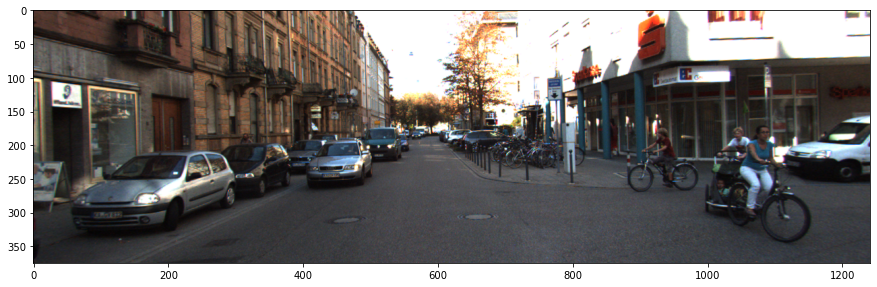

In [112]:
#collect images and pointclouds
images = sorted(glob.glob("2011_09_26_drive_0106_sync/image_02/data/*.png"))
pointclouds = sorted(glob.glob("2011_09_26_drive_0106_sync/velodyne_points/data/*.pcd"))

#Display one image and pointcloud indexed
index = 0
pcd_file = pointclouds[index]
img = plt.imread(images[index])
pcl = o3d.io.read_point_cloud(pcd_file)
pcl_points = np.asarray(pcl.points)        #pointcloud to numpy array
plt.figure(figsize=(15,15))
plt.imshow(img)          
# o3d.visualization.draw_geometries([pcl])   #visualize pointcloud

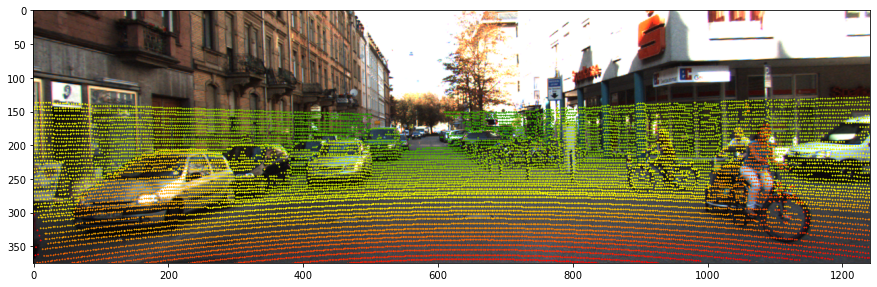

In [113]:
img_before = img.copy()
img_after = visualfusion.display_lidar_points_on_image(img_before,pcl_points)
plt.figure(figsize=(15,15))
plt.imshow(img_after)

In [97]:
images = sorted(glob.glob("2011_09_26_drive_0106_sync/image_02/data/*.png"))
pointclouds = sorted(glob.glob("2011_09_26_drive_0106_sync/velodyne_points/data/*.pcd"))

video = []
for idx, img in enumerate(images):
#     image = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
    image = plt.imread(img)
    image = np.zeros((image.shape[0],image.shape[1],3),dtype = np.uint8)
    point_cloud = np.asarray(o3d.io.read_point_cloud(pointclouds[idx]).points)
    video.append(visualfusion.display_lidar_points_on_image(image,point_cloud))
#     print(idx)
print("done")    

done


In [98]:
cv2.imshow("frame",video[0])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [100]:
print(len(video))
out = cv2.VideoWriter('video_result.avi',cv2.VideoWriter_fourcc(*'MJPG'), 10, (image.shape[1],image.shape[0]))

for i in range(len(video)):
    imgg = (video[i]*255).astype(np.uint8)
    out.write(cv2.cvtColor(imgg, cv2.COLOR_BGR2RGB))
out.release()
print('DONE')

227
DONE
